In [ ]:
# Based on the initial Prompt we will predict whether the given question will take high conversations or Low conversations to resolve the issue. 
#( For example if a question takes more than four prompts then we will assume that it will take more conversations to resolve the issue).

In [1]:
import pandas as pd
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from gensim import corpora, models
from sklearn.model_selection import train_test_split

In [2]:
# pip install --upgrade numpy
import warnings
warnings.filterwarnings("ignore")

In [3]:
file_path = "C:/Users/mohit/Downloads/DATASET.xlsx"
num_columns_to_read = len(pd.read_excel(file_path, nrows=1).columns)
df = pd.read_excel(file_path, usecols=range(num_columns_to_read))


# cleaning data
df['cleaned_text'] = df['Initial Prompt'].replace(r'\n', '', regex=True) #html cleaning
df['cleaned_text'] = df['Initial Prompt'].replace(r'<[^>]+>', '', regex=True) #html cleaning
df['cleaned_text'] = df['cleaned_text'].replace(r'http\S+', '', regex=True)
df['cleaned_text'] = df['cleaned_text'].replace(r'[^A-Za-z0-9\s]', '', regex=True)
df['cleaned_text'] = df['cleaned_text'].str.lower()

#removing stopwords
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def process_text(text):
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 1]
    return " ".join(tokens)

df['cleaned_text'] = df['cleaned_text'].apply(process_text)

# Display the first few rows of the processed data
df.head()

,Initial Prompt,Yes/No (Resolved or not),NumberOfPrompts,L/H (Low or High),Programming Language,which type of technology (DL/ML/WEB/None),cleaned_text
0,How to add a java class in a generic container...,Yes,3.0,L,Java,NaN,add java class generic container testcontainer...
1,How to run a java class inside of a container ...,Yes,2.0,L,Java,NaN,run java class inside container testcontainers
2,"I have a github repo on python, how to make it...",Yes,1.0,L,Python,NaN,github repo python make installable pip instal...
3,I'm using Terraform to manage some infrastruct...,Yes,2.0,L,HCL,NaN,im using terraform manage infrastructure gcp u...
4,I have a challenge for you. I'm working in a r...,No,8.0,H,TypeScript,WEB,challenge im working reacttypescript applicati...


In [32]:
print(df['L/H (Low or High)'].value_counts())
#Data processing
df['L/H (Low or High)']=df['L/H (Low or High)'].replace([':L','l'],'L')
print(df['L/H (Low or High)'].value_counts())
df['L/H (Low or High)']=df['L/H (Low or High)'].replace({'L':0,'H':1})
df['Yes/No (Resolved or not)']=df['Yes/No (Resolved or not)'].replace({'Yes':1,'No':0})
df['L/H (Low or High)']=df['L/H (Low or High)'].fillna(0)
print(df['L/H (Low or High)'].value_counts())


L/H (Low or High)
0.0    463
1.0    141
Name: count, dtype: int64
L/H (Low or High)
0.0    463
1.0    141
Name: count, dtype: int64
L/H (Low or High)
0.0    463
1.0    141
Name: count, dtype: int64


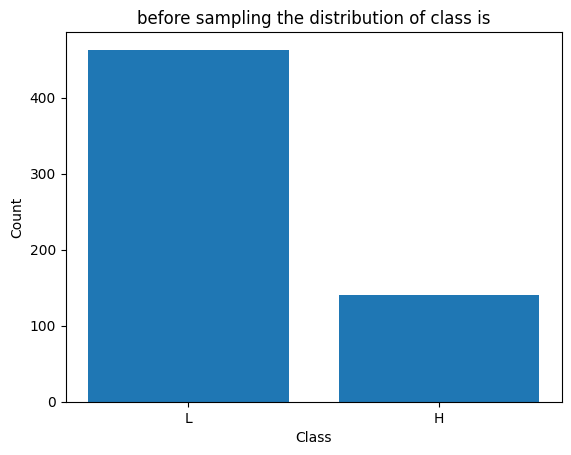

In [5]:
import matplotlib.pyplot as plt #
number= df['L/H (Low or High)'].value_counts()
plt.bar(['L','H'], number.values)

plt.xlabel('Class')
plt.ylabel('Count')
plt.title('before sampling the distribution of class is')
plt.show()

The most repeated word is 'using' with a count of 157.


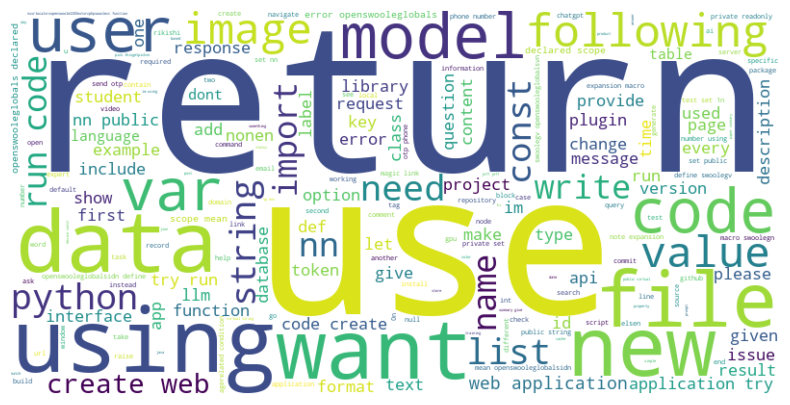

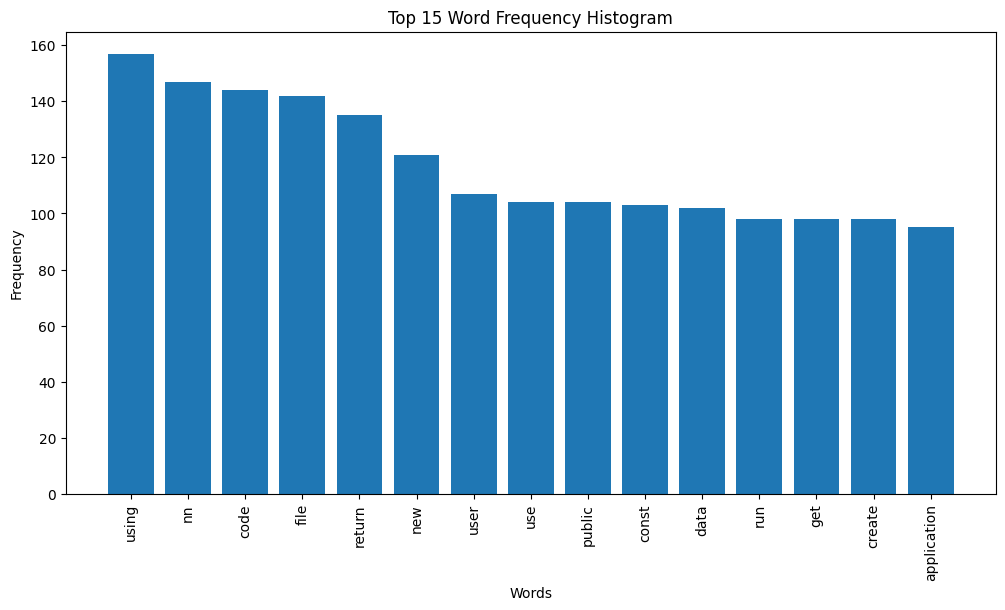

In [6]:
#finding most repeating word
def find_most_repeated_word(text):
    words = text.split()
    word_counts = Counter(words)
    most_repeated_word, count = word_counts.most_common(1)[0]
    return most_repeated_word, count

#generating word cloud
def generate_word_cloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

#generating histogram
def generate_histogram(text, top_n=15):
    words = text.split()
    word_counts = Counter(words)
    top_words, top_counts = zip(*word_counts.most_common(top_n))
    plt.figure(figsize=(12, 6))
    plt.bar(top_words, top_counts)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(f'Top {top_n} Word Frequency Histogram')
    plt.xticks(rotation=90)
    plt.show()


input_text = " ".join(df['cleaned_text'])

most_repeated_word, count = find_most_repeated_word(input_text)
print(f"The most repeated word is '{most_repeated_word}' with a count of {count}.")

generate_word_cloud(input_text)
generate_histogram(input_text)

In [7]:
#By using tf and idf vectorizing text data 
def calculate_tf_idf(corpus):
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)
    return tfidf_matrix.toarray()

def create_bag_of_words(corpus):
    count_vectorizer = CountVectorizer()
    bag_of_words = count_vectorizer.fit_transform(corpus)
    return bag_of_words

def train_word2vec_model(sentences, vector_size=100, window=5, min_count=1, sg=0):
    model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count, sg=sg)
    return model

In [13]:
#x_train_vectors = calculate_tf_idf(x_train['cleaned_text'])
#x_test_vectors = calculate_tf_idf(x_test['cleaned_text'])
vectors=calculate_tf_idf(df['cleaned_text'])


In [34]:
#Data sampaling to make data balance
from imblearn.over_sampling import SMOTE
over = SMOTE(sampling_strategy=0.8,random_state=42)
x_data_sampled,y_data_sampled=over.fit_resample(vectors,df['L/H (Low or High)'])
X_train, X_test, y_train, y_test = train_test_split(x_data_sampled,y_data_sampled, test_size=0.2, random_state=42)

In [35]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from sklearn.metrics import classification_report
from bs4 import BeautifulSoup

In [36]:
tags_2 = list(set(df['L/H (Low or High)']))

In [38]:
#implementing knn model
from sklearn.neighbors import KNeighborsClassifier
tr_scores=[]
for i in range(1,40,2):
    knn=KNeighborsClassifier(n_neighbors=i)
    #simple cross validation
    knn.fit(X_train,y_train)
    pred=knn.predict(X_test)
    acc = accuracy_score(y_pred, y_test, normalize=True) * float(100)
    tr_scores.append(acc)
    print('\n accuracy for k = %d is %f%%' % (i, acc))


 accuracy for k = 1 is 95.209581%

 accuracy for k = 3 is 95.209581%

 accuracy for k = 5 is 95.209581%

 accuracy for k = 7 is 95.209581%

 accuracy for k = 9 is 95.209581%

 accuracy for k = 11 is 95.209581%

 accuracy for k = 13 is 95.209581%

 accuracy for k = 15 is 95.209581%

 accuracy for k = 17 is 95.209581%

 accuracy for k = 19 is 95.209581%

 accuracy for k = 21 is 95.209581%

 accuracy for k = 23 is 95.209581%

 accuracy for k = 25 is 95.209581%

 accuracy for k = 27 is 95.209581%

 accuracy for k = 29 is 95.209581%

 accuracy for k = 31 is 95.209581%

 accuracy for k = 33 is 95.209581%

 accuracy for k = 35 is 95.209581%

 accuracy for k = 37 is 95.209581%

 accuracy for k = 39 is 95.209581%


In [39]:
#implemented gridsearch to find best paranmeters
from sklearn.model_selection import GridSearchCV
k_range = list(range(1,40,2))
print(k_range)
param_grid = dict(n_neighbors=k_range)
print(param_grid)
cnn=KNeighborsClassifier(algorithm='brute')

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39]
{'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39]}


In [22]:
# instantiate the grid
grid = GridSearchCV(cnn, param_grid, cv=10, scoring='accuracy', return_train_score=False)

In [23]:
# fit the grid with data
grid.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(algorithm='brute'),
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                         23, 25, 27, 29, 31, 33, 35, 37, 39]},
             scoring='accuracy')

In [24]:


# examine the best model
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)
     


0.7479194934418815
{'n_neighbors': 1}
KNeighborsClassifier(algorithm='brute', n_neighbors=1)


In [25]:
cvk_scores=[]
knn = KNeighborsClassifier(1)
knn.fit(X_train,y_train)
predk = knn.predict(X_test)
acck = accuracy_score(y_pred, y_test, normalize=True) * float(100)
print('\n****Test accuracy for k = 1 is %d%%' % (acck))


****Test accuracy for k = 1 is 95%


In [27]:
from sklearn.metrics import roc_auc_score

trains_auc_score=[]
preda=knn.predict(X_test)
auc = roc_auc_score(y_test, y_pred) * float(100)
trains_auc_score.append(auc)
print('\n AUC on test data is %d%%' % (auc))
     



 AUC on test data is 95%


In [28]:
cmx = confusion_matrix(preda,y_test)#plot confusion matrix on predictions and y test

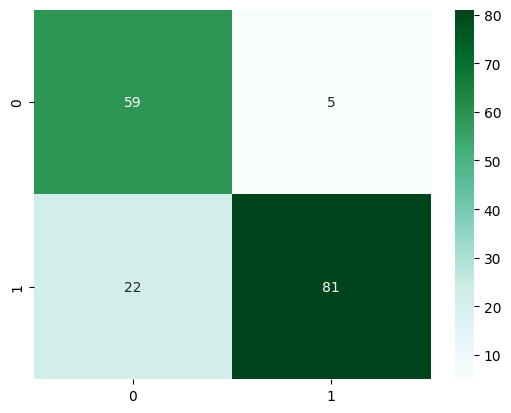

In [29]:
#ploting confusionmatrix
import seaborn as sns
     
cm = sns.heatmap(cmx, annot = True, fmt = 'd', cmap = 'BuGn')
     